Semi-supervised learning.  
Encoding-past CAE network.  
Use 3d spatio-temporal conv kernels.  

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
import pandas as pd
import pickle as pkl
#import winsound#sound alarm when code finishes, only in windows

from SemiNE3d.utils import *
from SemiNE3d.train import *
from chirpMB import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 100
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=2e-4 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
print (torch.cuda.is_available())

True


In [4]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [5]:
training_inputs = np.load('../data/fig6_training_inputs.npy')
training_set = np.load('../data/fig6_training_set.npy')
test_inputs = np.load('../data/fig6_test_inputs.npy')
test_set = np.load('../data/fig6_test_set.npy')
movie_bgr_h5 = np.load('../data/fig6_movie_bgr_h5.npy')

In [6]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
'''
for ii in range(20):
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*1800:ii*1800+1800] # [ii*1800:ii*1800+1800]
    temp=(temp0,temp1,temp2)
    train_loader.append(temp)
'''
'''
for ii in range(8): # 40% of data
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*4500:ii*4500+4500] # [ii*1800:ii*1800+1800]
    temp=(temp0,temp1,temp2)
    train_loader.append(temp)
'''
for ii in range(12): # 60% of data
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*3000:ii*3000+3000] 
    temp=(temp0,temp1,temp2)
    train_loader.append(temp)
#
temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
temp2=movie_bgr_h5[36000:39200]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[39200:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
12
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 427)
shape of train_loader[0][2]:
(3000, 2, 9, 28, 28)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 427)
shape of val_loader[2]:
(3200, 2, 9, 28, 28)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 427)
shape of test_loader[2]:
(800, 2, 9, 28, 28)


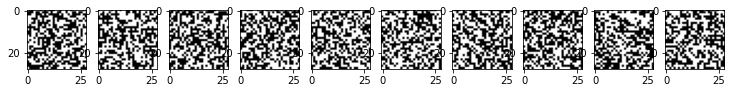

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

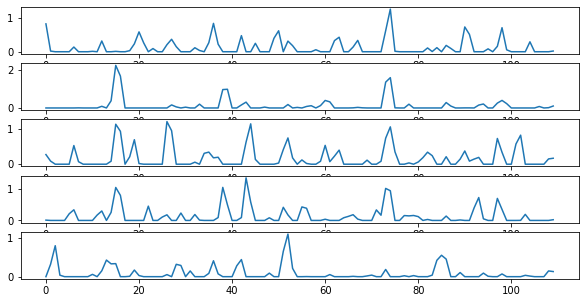

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

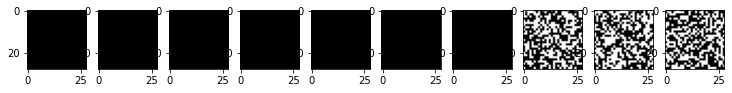

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

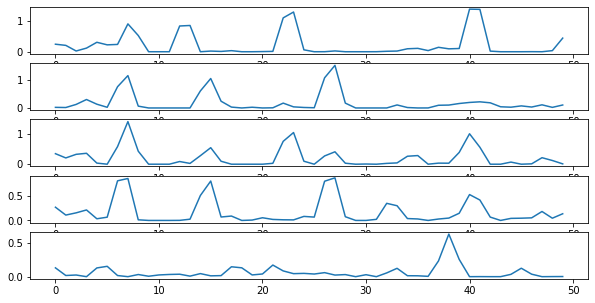

In [10]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

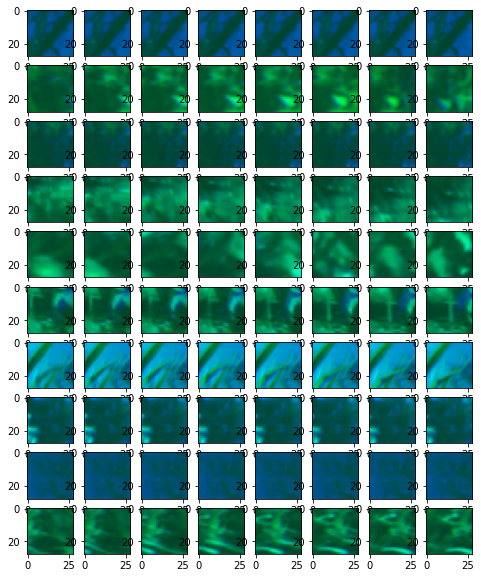

In [11]:
fig, axes = plt.subplots(nrows=10, ncols=8,figsize=(8,10))
for ii in range(10):
    for jj in range(8):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.transpose(train_loader[5][2][ii][:,jj,:,:],(1,2,0))[...,::-1]
        axes[ii,jj].imshow(img_real2view(temp))
        axes[ii,jj].grid(False)#axes[ii,jj].axis('tight')

In [12]:
#preprocess: centered data
#sky_bg_mean_f   =(0.10539950580232095, 0.23792787064825932)
sky_bg_mean_f   = np.mean(movie_bgr_h5[:36000,:,:-1,:,:],axis=(0,2,3,4))/255.0
print(sky_bg_mean_f)

[0.19401256 0.20572354]


In [13]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle,save=False,filename=None): # conv3d_0.shape (16, 2, 8, 9, 9)
    (outd,_,_,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=3, ncols=outd,figsize=(outd, 3))
    for jj in range(outd):
        nt = 8 # time lag
        ny = 9
        nx = 9
        dims = [nt, ny, nx]
        [sRF_UV, tRF_UV]=mySVD(conv3d_0[jj,0], dims)
        [sRF_G, tRF_G]=mySVD(conv3d_0[jj,1], dims)
        tempmax=np.max(np.abs([sRF_UV,sRF_G]))
        axes[0,jj].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[0,jj].set_xticks([])
        axes[0,jj].set_yticks([])
        axes[0,jj].set_title('%d' %(jj))
        axes[1,jj].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].set_xticks([])
        axes[1,jj].set_yticks([])
        axes[2,jj].plot(tRF_G,color='g')
        axes[2,jj].plot(tRF_UV,color='purple')
        axes[2,jj].axhline(y=0,color='k')
        axes[2,jj].spines['left'].set_visible(False)
        axes[2,jj].spines['bottom'].set_visible(False)
        axes[2,jj].spines['right'].set_visible(False)
        axes[2,jj].spines['top'].set_visible(False)
        axes[2,jj].set_xticks([])
        axes[2,jj].set_yticks([])
        axes[0,0].set_ylabel(str(temptitle))
        axes[0,0].set_title('%d_UV' %(0))
    if save==True:
        fig.savefig(filename)

##  <font color='red'>Model architecture</font> 

In [14]:
class ModelSemiSL3d1_Conv3d_1(nn.Module):
    def __init__(self):
        super().__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=427 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #
        self.ae_dconv1 =nn.ConvTranspose2d(self.numoffea,2,kernel_size=9,stride=1,padding=4) #2,28*28
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            #GaussianNoise(sigma=0)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten(-1,self.numoffea,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_Conv3d_1_copy(nn.Module):
    def __init__(self,conv1,conv1_bias,fc1_weight,fc1_bias):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=427 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1.data.copy_(conv1.clone().detach())
        self.conv1_bias.data.copy_(conv1_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Different weights</font> 

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100
LR=3e-4 # 2e-4
batch_num = 8
alpha1s = [1e3] # [1e3]
alpha2s = [0] #not play a role
beta1s  =[1/16] # [1/4]
alpha3s =[1e5] # [1e3]
beta2s  =[1/16, 1/4, 1]
seeds   =[1]
lossweights=[0.8, 0.7, 0.6, 0.5] # [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
modelvalloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
modeltestloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
for ii in range(len(alpha3s)):
    for jj in range(len(beta2s)):
        for kk in range(len(lossweights)):
            torch.manual_seed(seeds[0])    # reproducible
            torch.cuda.manual_seed(seeds[0])
            tempmodel = ModelSemiSL3d1_Conv3d_1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_num],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[ii],beta2=beta2s[jj],lossweight=lossweights[kk],earlystop=True,verbose=False) 
        
            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            print ('Val CC: {}'.format(temp))
            modelvalloss[ii,jj,kk]=temp
            temp,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            #print (temp)
            modeltestloss[ii,jj,kk]=temp
            del tempmodel
            torch.cuda.empty_cache()

2021-07-12 21:02:59.832207
Epoch: 80 val loss: 0.2786, finish training!
2021-07-12 21:16:07.785581
Val CC: 0.2785876882267328
Overall pearson correlation coefficient:  0.44644673349097796  and p-value:  0.0
2021-07-12 21:16:19.484079


In [20]:
'''
traing natural: 12x3000
batch_num = 8
alpha3s =[1e4, 1e5, 1e6] # [1e3]
beta2s  =[1/16, 1/4, 1]
seeds   =[1]
lossweights=[0.7, 0.6, 0.5]
best model: alpha3s =[1e5], beta2s =[1/4], lossweights=[0.7]
'''
print (np.max(modelvalloss))
print (np.argmax(modelvalloss))
print (modelvalloss)
print (np.max(modeltestloss))
print (np.argmax(modeltestloss))
print (modeltestloss)

0.29502919354002927
12
[[[0.26914011 0.2699396  0.27365511]
  [0.26741906 0.2714158  0.27667903]
  [0.25547621 0.25872099 0.2638304 ]]

 [[0.29450908 0.21325175 0.20821999]
  [0.29502919 0.20552749 0.20666129]
  [0.28363882 0.28703146 0.21298911]]

 [[0.20572931 0.20571886 0.20568464]
  [0.20576266 0.20572907 0.20538552]
  [0.20577404 0.20576665 0.20575236]]]
0.4751261273033123
9
[[[0.42217436 0.42318199 0.42971829]
  [0.4215931  0.42839343 0.43870756]
  [0.39964095 0.40473834 0.4129283 ]]

 [[0.47512613 0.31093197 0.30169489]
  [0.47509759 0.29523307 0.29898374]
  [0.45361296 0.45249616 0.30898702]]

 [[0.29619633 0.29629909 0.2964506 ]
  [0.29642525 0.29637019 0.29680709]
  [0.29614446 0.29625268 0.29611504]]]


In [ ]:
'''
traing natural: 10x3600
batch_num = 8
alpha3s =[1e5] # [1e3]
beta2s  =[1/16, 1/4, 1]
seeds   =[1]
lossweights=[0.8, 0.7, 0.6, 0.5]
best model: alpha3s =[1e5], beta2s =[1/4], lossweights=[0.7]
'''
print (np.max(modelvalloss))
print (np.argmax(modelvalloss))
print (modelvalloss)
print (np.max(modeltestloss))
print (np.argmax(modeltestloss))
print (modeltestloss)

## Test and check conv

2021-07-13 09:34:17.954238
Epoch: 98 val loss: 0.2902, finish training!
2021-07-13 09:50:54.534345
Val CC: 0.29021722734405736
Overall pearson correlation coefficient:  0.46821700894094603  and p-value:  0.0


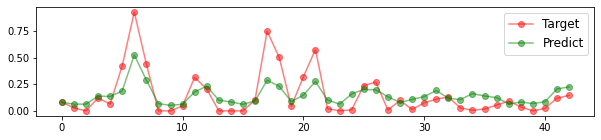

In [21]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100
LR=3e-4 # 2e-4
batch_num = 8
alpha1s = [1e3] # [1e3]
alpha2s = [0] #not play a role
beta1s  =[1/16] # [1/4]
alpha3s =[1e5] # [1e3]
beta2s  =[1/4]
seeds   =[1]
lossweights=[0.7] 
modelvalloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
modeltestloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
for ii in range(len(alpha3s)):
    for jj in range(len(beta2s)):
        for kk in range(len(lossweights)):
            torch.manual_seed(seeds[0])    # reproducible
            torch.cuda.manual_seed(seeds[0])
            tempmodel = ModelSemiSL3d1_Conv3d_1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_num],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[ii],beta2=beta2s[jj],lossweight=lossweights[kk],earlystop=True,verbose=False) 
            torch.save(tempmodel.state_dict(),\
            './out/20200429_v5_ModelSemiSL3d1_Conv3d_1_ventral_less_upandlow_seed_test1'+'.pth')
            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            print ('Val CC: {}'.format(temp))
            modelvalloss[ii,jj,kk]=temp
            temp,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            #print (temp)
            modeltestloss[ii,jj,kk]=temp
            del tempmodel
            torch.cuda.empty_cache()

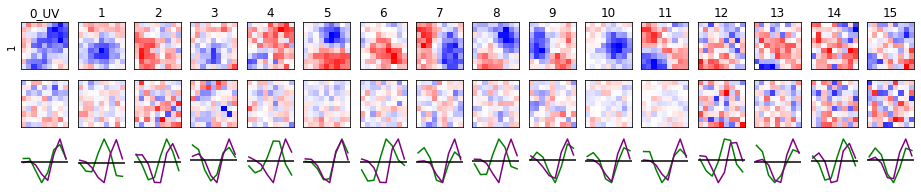

In [22]:
# traing natural: 12x3000
modelname=[1]
temptitle=1
for ii in range(len(modelname)):
    tempmodel= ModelSemiSL3d1_Conv3d_1()
    tempmodel.load_state_dict(torch.load\
                ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_1_ventral_less_upandlow_seed_test1'+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=tempmodel.conv1.cpu().data.numpy()
    
    Vis_conv3d_0(conv3d_0,temptitle,save=False,\
        filename='out_result/20200429_ModelSemiSL3d1_Conv3d_1_ventral_less_upandlow_test1_conv0_v5.svg')
    temptitle=temptitle+1
    torch.cuda.empty_cache()

## Calculate R-squared of conv

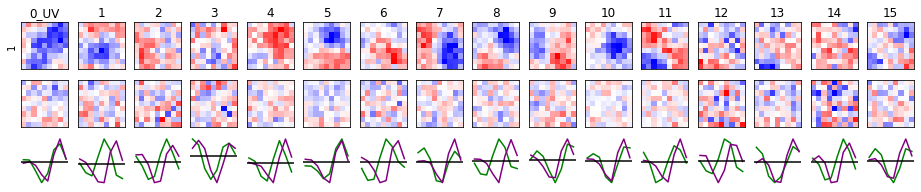

In [36]:
modelname=[2] # np.arange(1,10) #np.arange(1,3) [1,3,5,7]
plt.rcParams.update({'figure.max_open_warning': 0})
temptitle=1
for ii in range(len(modelname)):
    #print (ii)
    #print ('\n')
    #load model
    tempmodel= ModelSemiSL3d1_Conv3d_1()
    tempmodel.load_state_dict(torch.load\
                ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_1_ventral_less_upandlow_seed_1_weight_'+str(modelname[ii])+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    #get parameters of model
    #conv3d_0=tempmodel.encoder[0].weight.cpu().data.numpy()
    conv3d_0=tempmodel.conv1.cpu().data.numpy()
    
    Vis_conv3d_0(conv3d_0,temptitle,save=False,\
        filename='out_result/20200429_ModelSemiSL3d1_Conv3d_1_ventral_less_upandlow_weight_2_conv0_v5.svg')
    temptitle=temptitle+1
    torch.cuda.empty_cache()

In [20]:
#Use non-linear least squares to fit a 2d Gaussian function to conv0 and then measure the goodness of fit by r2
conv1_ss_s=[]
r2_s=[]
seeds=np.arange(1,11)
width,height=9,9
nt = 8 # time lag
ny = 9
nx = 9
dims = [nt, ny, nx]
for seed in seeds:
    tempmodel= ModelSemiSL3d1_Conv3d_1()
    tempmodel.load_state_dict(torch.load\
                ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_seed_'+str(seed)+'_weight_6.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=tempmodel.conv1.cpu().data.numpy() #shape (16,2,8,9,9)
    conv3d_0=np.reshape(conv3d_0,(-1,nt,ny,nx))
    for ii in range(len(conv3d_0)):
        [conv1_ss,_]=mySVD(conv3d_0[ii], dims)
        conv1_ss_s.append(conv1_ss)
conv1_ss_s=np.array(conv1_ss_s)
print (conv1_ss_s.shape)
conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
print (conv1_ss_s.shape)
#
for ii in range(len(conv1_ss_s)):
    fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
    fit_2dgaussian.fit()
    r2_s.append(fit_2dgaussian.cal_r2())
r2_s=np.array(r2_s)
print (np.median(r2_s))
print (np.mean(r2_s))

(320, 9, 9)
(320, 81)


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.19111948474959772
0.33546125891640366


## Plot celltypes

In [37]:
# save data for sharing
# celltypes.to_pickle('publicDataCode/Data/fig6_celltypes.pkl')
with open('../data/fig6_celltypes.pkl', "rb") as f:
    celltypes = pkl.load(f)

display(celltypes)

,Cell,Group,Confidence,Chirps,MBs,Ds-i,Ds-p,Os-i,Os-p,QIs,...,ON-OFF,FastON,SlowON,Uncertain,AC,DS,NonDS,CCs-Semi,CCs-Semi2,CCs-SE
0,0,10,0.25,"[[0.13438753272120016, 0.14213727157585027, 0....","[[[0.21344310516158288, 0.3621119788221963, 0....",0.032997,0.443,0.109307,0.001,"[0.7761449152888461, 0.3337780731605859, 0.927...",...,1,-1,-1,-1,-1,-1,1,"[0.3730410362043929, 0.25068612135701274, 0.24...","[0.40019575581523004, 0.24673189204945348, 0.2...","[0.17793327649295532, 0.11151319410069646, 0.0..."
1,1,42,0.23,"[[0.1320688613558673, 0.1114897990882257, 0.11...","[[[0.16605434073980768, 0.1607119650563959, 0....",0.025519,0.673,0.100484,0.0,"[0.6696051603256693, 0.2881491724762844, 0.935...",...,-1,-1,-1,-1,1,-1,1,"[0.5542958699680619, 0.41472577030603275, 0.51...","[0.5446690729166692, 0.39744319089872593, 0.52...","[0.34780802036367386, 0.35867480532077617, 0.4..."
2,2,43,0.29,"[[0.13854897717481254, 0.30530040644489365, 0....","[[[1.0, 0.6485097735019756, 0.1512905744048158...",0.072211,0.489,0.071088,0.109,"[0.6500170334220716, 0.4621776909396695, 0.599...",...,-1,-1,-1,-1,1,-1,1,"[0.4482670759045563, 0.27819911140640946, 0.46...","[0.4469089858768502, 0.270801382752086, 0.4615...","[0.41878915209903156, 0.12416440049977366, 0.3..."
3,3,12,0.53,"[[0.046724026060362314, 0.005227445995680658, ...","[[[0.05458548979281042, 0.11734645414865867, 0...",0.040844,0.062,0.053729,0.016,"[0.6012290934815921, 0.5541566330057817, 0.941...",...,1,-1,-1,-1,-1,-1,1,"[0.15904340059292704, 0.25215693522765537, 0.3...","[0.16517665000418552, 0.2686642387645859, 0.40...","[-0.029439419198868486, 0.20461232594696452, 0..."
4,4,31,0.58,"[[1.0, 0.9722854575622821, 0.8456900610312926,...","[[[0.26135564880509815, 0.1661990404920401, 0....",0.053732,0.242,0.131992,0.001,"[0.528797652287789, 0.2743532982228195, 0.5926...",...,-1,-1,-1,1,-1,-1,1,"[0.13125923851632665, 0.06674070200980717, 0.1...","[0.1321250068227786, 0.06978520372428344, 0.12...","[0.23700100738957372, -0.044160519580388385, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,422,-1,-1,"[[0.14235584056759054, 0.026616836934846323, 0...","[[[0.2415856321065215, 0.07197937224466126, 0....",0.04338,0.197,0.02422,0.323,"[0.26297073730534953, 0.30164727744471403, 0.5...",...,-1,-1,-1,-1,-1,-1,-1,"[0.09082736756508356, 0.1323184169203889, 0.15...","[0.13791653695668674, 0.1520680467415347, 0.12...","[0.18328486841384026, 0.043067134822925145, 0...."
423,423,17,0.54,"[[0.21000508388402986, 0.15163628440694943, 0....","[[[0.23543759230583272, 0.2233538830641558, 0....",0.057987,0.264,0.085494,0.206,"[0.26227543838354683, 0.27589218405321636, 0.6...",...,-1,1,-1,-1,-1,-1,1,"[0.3108108090038242, 0.19507419362884101, 0.20...","[0.3100067801250225, 0.20885640027847935, 0.18...","[0.27102115967877244, 0.06849524615836014, 0.2..."
424,424,38,0.58,"[[0.41852949362322783, 0.25224374191634363, 0....","[[[0.24505068093728585, 0.29097818487189486, 0...",0.028135,0.39,0.030195,0.246,"[0.2608488866647364, 0.5465794080548443, 0.879...",...,-1,-1,-1,-1,1,-1,1,"[0.1890766675375603, 0.22534971689195227, 0.22...","[0.18114406341078085, 0.2404017023632196, 0.21...","[0.25026046273737196, 0.13847908757015912, 0.1..."
425,425,42,0.51,"[[0.33426150356509493, 0.4373962438276083, 0.0...","[[[0.19024501804029842, 0.18715935135605305, 0...",0.047486,0.106,0.054735,0.107,"[0.2595402476486674, 0.408702050761244, 0.7332...",...,-1,-1,-1,-1,1,-1,1,"[0.0497513766421305, 0.01265891931382822, 0.17...","[0.04514860113316732, -0.005470472467940182, 0...","[0.21942819076983142, -0.03226484856398816, 0...."


(35,) 0.05319711162738185
(59,) 0.05191323174497185
(49,) 0.04328878488132401
(38,) 0.049968605501436066
(64,) 0.048217580027796324
(145,) 0.048854183504947545
[0.8981, 0.3256, 0.7462, 0.6022, 0.5761, 0.305, 0.8332, 0.6519, 0.6259, 0.445, 0.5393, 0.3961, 0.8422, 0.8758, 0.915]


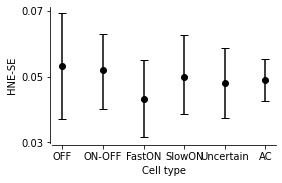

In [17]:
#HNE-SE: (DS) vs. FastON, SlowON, ..., mean with bootstrap
xx = np.vstack(celltypes.loc[:,'CCs-Semi'].values).mean(axis=1) - np.vstack(celltypes.loc[:,'CCs-SE'].values).mean(axis=1)
#cell_types = ['DS', 'FastON', 'SlowON', 'ON-OFF', 'OFF', 'Uncertain', 'AC']
cell_types = ['OFF', 'ON-OFF', 'FastON', 'SlowON', 'Uncertain', 'AC'] 
xx_cell_types = []
for ii in range(len(cell_types)):
    xx_cell_types.append(xx[np.where((celltypes[cell_types[ii]]>0)  )])
    print (xx_cell_types[ii].shape, np.mean(xx_cell_types[ii]))

def perm_test(xs, ys, nmc=10000, randomseed=66):
    '''
    n, k = len(xs), 0
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(ys)
        k += np.mean(xs) < np.mean(ys[:n])
    '''
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
temps=[ii for ii in xx_cell_types]
print (perm_test_group(temps,nmc=10000,randomseed=66))

#plot OFF/ON as RF size with bootstrapping
means = [np.mean(ii) for ii in xx_cell_types]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
#plot
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks(np.arange(len(means)).tolist())
ax.set_xticklabels(cell_types)
ax.set_yticks([0.03, 0.05, 0.07])
ax.set_xlabel('Cell type')
ax.set_ylabel('HNE-SE')
adjust_spines(ax, ['left', 'bottom'])
#plt.tight_layout()

(35,) 0.05235042435197318
(59,) 0.052170959499093304
(49,) 0.04565560216217166
(38,) 0.05060105335382027
(64,) 0.04844474526369572
(145,) 0.049594147624558896
[0.9847, 0.5091, 0.8596, 0.6857, 0.7266, 0.4307, 0.8656, 0.6505, 0.6774, 0.5714, 0.7266, 0.5505, 0.8042, 0.8857, 0.8451]


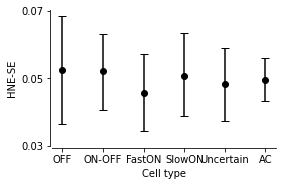

In [18]:
#HNEfuture-SE: (DS) vs. FastON, SlowON, ..., mean with bootstrap
xx = np.vstack(celltypes.loc[:,'CCs-Semi2'].values).mean(axis=1) - np.vstack(celltypes.loc[:,'CCs-SE'].values).mean(axis=1)
#cell_types = ['DS', 'FastON', 'SlowON', 'ON-OFF', 'OFF', 'Uncertain', 'AC']
cell_types = ['OFF', 'ON-OFF', 'FastON', 'SlowON', 'Uncertain', 'AC'] 
xx_cell_types = []
for ii in range(len(cell_types)):
    xx_cell_types.append(xx[np.where((celltypes[cell_types[ii]]>0)  )])
    print (xx_cell_types[ii].shape, np.mean(xx_cell_types[ii]))

def perm_test(xs, ys, nmc=10000, randomseed=66):
    '''
    n, k = len(xs), 0
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(ys)
        k += np.mean(xs) < np.mean(ys[:n])
    '''
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
temps=[ii for ii in xx_cell_types]
print (perm_test_group(temps,nmc=10000,randomseed=66))

#plot OFF/ON as RF size with bootstrapping
means = [np.mean(ii) for ii in xx_cell_types]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
#plot
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks(np.arange(len(means)).tolist())
ax.set_xticklabels(cell_types)
ax.set_yticks([0.03, 0.05, 0.07])
ax.set_xlabel('Cell type')
ax.set_ylabel('HNE-SE')
adjust_spines(ax, ['left', 'bottom'])
#plt.tight_layout()

In [19]:
#for test
#np.where((celltypes['DS']>0) & (celltypes['AC']<0) )[0].shape
xx = np.vstack(celltypes.loc[:,'CCs-Semi'].values).mean(axis=1) - np.vstack(celltypes.loc[:,'CCs-SE'].values).mean(axis=1)
xx_ds = xx[np.where((celltypes['DS']>0) & (celltypes['AC']<0)  )]
xx_nonds = xx[np.where((celltypes['NonDS']>0) | (celltypes['AC']>0) )]
print (xx_ds.shape, xx_nonds.shape)
print (np.mean(xx_ds), np.mean(xx_nonds))
def perm_test(xs, ys, nmc=10000, randomseed=66):
    '''
    n, k = len(xs), 0
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(ys)
        k += np.mean(xs) < np.mean(ys[:n])
    '''
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
print (perm_test(xx_ds, xx_nonds))

(70,) (320,)
0.05853276501952224 0.04692882883369047
0.0361


(90,) (300,)
0.06065508066756723 0.045518538393554867
0.0027


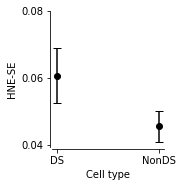

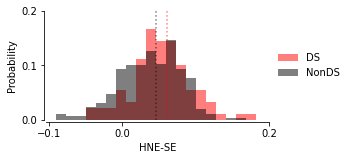

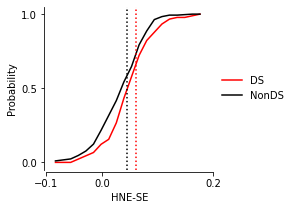

In [20]:
#HNE-SE: DS vs. nonDS, mean with bootstrap, distribution of mean performance improvement for 10 seeds
xx = np.vstack(celltypes.loc[:,'CCs-Semi'].values).mean(axis=1) - np.vstack(celltypes.loc[:,'CCs-SE'].values).mean(axis=1)
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
print (xx_ds.shape, xx_nonds.shape)
print (np.mean(xx_ds), np.mean(xx_nonds))
def perm_test(xs, ys, nmc=10000, randomseed=66):
    '''
    n, k = len(xs), 0
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(ys)
        k += np.mean(xs) < np.mean(ys[:n])
    '''
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
print (perm_test(xx_ds, xx_nonds))

#plot OFF/ON as RF size with bootstrapping
means = [np.mean(xx_ds), np.mean(xx_nonds)]
temps = [xx_ds, xx_nonds]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
#plot
cell_types =['DS', 'NonDS']
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks([0,1])
ax.set_xticklabels(cell_types)
ax.set_yticks([0.04, 0.06, 0.08])
ax.set_xlabel('Cell type')
ax.set_ylabel('HNE-SE')
adjust_spines(ax, ['left', 'bottom'])
#plt.tight_layout()
#fig.savefig('out_result/20200429_ventral_less_dsnonds_bootstrap.svg')

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(4,2))
data = np.copy(xx_ds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
axes.bar(bins[:-1], hist, w, alpha=0.5, color='r', label='DS')
data = np.copy(xx_nonds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
axes.bar(bins[:-1], hist, w, alpha=0.5, color='k', label='NonDS')
axes.axvline(x=np.mean(xx_ds), color='r', linestyle=':', alpha=0.5)
axes.axvline(x=np.mean(xx_nonds), color='k', linestyle=':', alpha=0.5)
axes.set_xticks([-0.1, 0, 0.2])
axes.set_xlabel('HNE-SE')
axes.set_yticks([0, 0.1, 0.2])
axes.set_ylabel('Probability')
adjust_spines(axes, ['left', 'bottom'])
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_ventral_less_dsnonds_past_hist.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
data = np.copy(xx_ds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
#axes.bar(bins[:-1], hist, w, alpha=0.5, color='r', label='DS')
cumulative = np.cumsum(hist)
axes.plot(bins[:-1], cumulative, alpha=1, color='r', label='DS')
data = np.copy(xx_nonds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
#axes.bar(bins[:-1], hist, w, alpha=0.5, color='k', label='NonDS')
cumulative = np.cumsum(hist)
axes.plot(bins[:-1], cumulative, alpha=1, color='k', label='NonDS')
axes.axvline(x=np.mean(xx_ds), color='r', linestyle=':', alpha=1)
axes.axvline(x=np.mean(xx_nonds), color='k', linestyle=':', alpha=1)
axes.set_xticks([-0.1, 0, 0.2])
axes.set_xlabel('HNE-SE')
axes.set_yticks([0, 0.5, 1])
axes.set_ylabel('Probability')
adjust_spines(axes, ['left', 'bottom'])
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_ventral_less_dsnonds_past_cdf.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

(90,) (300,)
0.06066070854749109 0.04634155776440172
0.0042


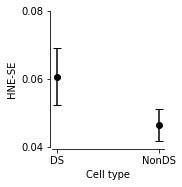

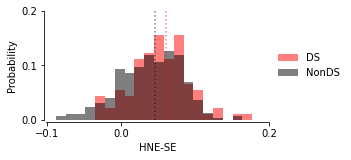

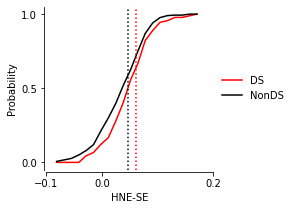

In [21]:
#HNEfuture-SE: DS vs. nonDS, mean with bootstrap, distribution of mean performance improvement for 10 seeds
xx = np.vstack(celltypes.loc[:,'CCs-Semi2'].values).mean(axis=1) - np.vstack(celltypes.loc[:,'CCs-SE'].values).mean(axis=1)
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
print (xx_ds.shape, xx_nonds.shape)
print (np.mean(xx_ds), np.mean(xx_nonds))
def perm_test(xs, ys, nmc=10000, randomseed=66):
    '''
    n, k = len(xs), 0
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(ys)
        k += np.mean(xs) < np.mean(ys[:n])
    '''
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
print (perm_test(xx_ds, xx_nonds))

#plot OFF/ON as RF size with bootstrapping
means = [np.mean(xx_ds), np.mean(xx_nonds)]
temps = [xx_ds, xx_nonds]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
#plot
cell_types =['DS', 'NonDS']
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks([0,1])
ax.set_xticklabels(cell_types)
ax.set_yticks([0.04, 0.06, 0.08])
ax.set_xlabel('Cell type')
ax.set_ylabel('HNE-SE')
adjust_spines(ax, ['left', 'bottom'])
#plt.tight_layout()
#fig.savefig('out_result/20200429_ventral_less_dsnonds_bootstrap_future.svg')

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(4,2))
data = np.copy(xx_ds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
axes.bar(bins[:-1], hist, w, alpha=0.5, color='r', label='DS')
data = np.copy(xx_nonds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
axes.bar(bins[:-1], hist, w, alpha=0.5, color='k', label='NonDS')
axes.axvline(x=np.mean(xx_ds), color='r', linestyle=':', alpha=0.5)
axes.axvline(x=np.mean(xx_nonds), color='k', linestyle=':', alpha=0.5)
axes.set_xticks([-0.1, 0, 0.2])
axes.set_xlabel('HNE-SE')
axes.set_yticks([0, 0.1, 0.2])
axes.set_ylabel('Probability')
adjust_spines(axes, ['left', 'bottom'])
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_ventral_less_dsnonds_future_hist.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
data = np.copy(xx_ds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
#axes.bar(bins[:-1], hist, w, alpha=0.5, color='r', label='DS')
cumulative = np.cumsum(hist)
axes.plot(bins[:-1], cumulative, alpha=1, color='r', label='DS')
data = np.copy(xx_nonds)
weights = np.ones_like(data)/len(data)
hist, bins = np.histogram(data, range=[xx.min(), xx.max()], bins=20, weights=weights)
w = bins[1] - bins[0]  # Bar width
#axes.bar(bins[:-1], hist, w, alpha=0.5, color='k', label='NonDS')
cumulative = np.cumsum(hist)
axes.plot(bins[:-1], cumulative, alpha=1, color='k', label='NonDS')
axes.axvline(x=np.mean(xx_ds), color='r', linestyle=':', alpha=1)
axes.axvline(x=np.mean(xx_nonds), color='k', linestyle=':', alpha=1)
axes.set_xticks([-0.1, 0, 0.2])
axes.set_xlabel('HNE-SE')
axes.set_yticks([0, 0.5, 1])
axes.set_ylabel('Probability')
adjust_spines(axes, ['left', 'bottom'])
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_ventral_less_dsnonds_future_cdf.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

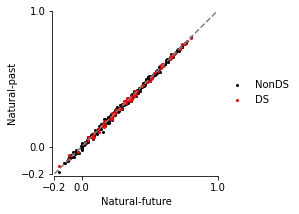

In [22]:
#scatter plot HNEpast-HNEfuture, for one seed
tempmin=-0.2
tempmax=1
num = 1 # group number
colors = ['k', 'r'] #cm.rainbow(np.linspace(0, 1, num))
labels = ['NonDS', 'DS']
#
fig,axes=plt.subplots(nrows=1,ncols=num,figsize=(3,3))
axes.plot([tempmin,tempmax],[tempmin,tempmax],color='gray',linestyle='--')
axes.set_xlim([tempmin,tempmax])
axes.set_ylim([tempmin,tempmax])
axes.set_xticks([tempmin,0,tempmax])
axes.set_yticks([tempmin,0,tempmax])
adjust_spines(axes, ['left', 'bottom'])
axes.set_aspect('equal', 'box')
for ii in range(len(labels)):    
    tempSemi = np.vstack(celltypes.loc[celltypes[labels[ii]] == 1,'CCs-Semi'].values)[:,0]
    tempSemi2 = np.vstack(celltypes.loc[celltypes[labels[ii]] == 1,'CCs-Semi2'].values)[:,0]
    axes.scatter(tempSemi2,tempSemi,s=4, color=colors[ii], label=labels[ii],alpha=1)
#axes.set_title(labels[ii])
#axes[ii].set_title(labels[ii]+' {:.2f}'.format(len(np.where(tempSE<tempSemi)[0])/len(tempSE)))
axes.set_xlabel('Natural-future')
axes.set_ylabel('Natural-past')
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#plt.tight_layout()

(90,) (300,)
0.42004934471178834 0.40434166085106693
0.2881
(90,) (300,)
0.5651247610569194 0.5758579654713871
0.6714
(90,) (300,)
0.8048040499291097 0.728619634366134
0.0


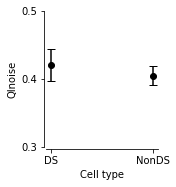

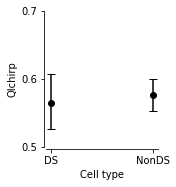

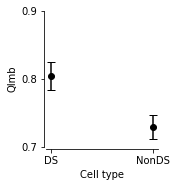

In [23]:
#QI plot for DS and nonDS
saveflag = False
def perm_test(xs, ys, nmc=10000, randomseed=66):
    '''
    n, k = len(xs), 0
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(ys)
        k += np.mean(xs) < np.mean(ys[:n])
    '''
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc

xx = np.vstack(celltypes.loc[:,'QIs'].values)[:,0]
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
print (xx_ds.shape, xx_nonds.shape)
print (np.mean(xx_ds), np.mean(xx_nonds))
print (perm_test(xx_ds, xx_nonds))
#bootstrapping
means = [np.mean(xx_ds), np.mean(xx_nonds)]
temps = [xx_ds, xx_nonds]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#plot
cell_types =['DS', 'NonDS']
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks([0,1])
ax.set_xticklabels(cell_types)
ax.set_yticks([0.3, 0.4, 0.5])
ax.set_xlabel('Cell type')
ax.set_ylabel('QInoise')
adjust_spines(ax, ['left', 'bottom'])
if saveflag == True:
    fig.savefig('out_result/20200429_ventral_less_dsnonds_QInoise.svg')

xx = np.vstack(celltypes.loc[:,'QIs'].values)[:,1]
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
print (xx_ds.shape, xx_nonds.shape)
print (np.mean(xx_ds), np.mean(xx_nonds))
print (perm_test(xx_ds, xx_nonds))
#bootstrapping
means = [np.mean(xx_ds), np.mean(xx_nonds)]
temps = [xx_ds, xx_nonds]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#plot
cell_types =['DS', 'NonDS']
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks([0,1])
ax.set_xticklabels(cell_types)
ax.set_yticks([0.5, 0.6, 0.7])
ax.set_xlabel('Cell type')
ax.set_ylabel('QIchirp')
adjust_spines(ax, ['left', 'bottom'])
if saveflag == True:
    fig.savefig('out_result/20200429_ventral_less_dsnonds_QIchirp.svg')

xx = np.vstack(celltypes.loc[:,'QIs'].values)[:,2]
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
print (xx_ds.shape, xx_nonds.shape)
print (np.mean(xx_ds), np.mean(xx_nonds))
print (perm_test(xx_ds, xx_nonds))
#bootstrapping
means = [np.mean(xx_ds), np.mean(xx_nonds)]
temps = [xx_ds, xx_nonds]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#plot
cell_types =['DS', 'NonDS']
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,2.5))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),marker='o',color='k',linestyle='None',capsize=4)
ax.set_xticks([0,1])
ax.set_xticklabels(cell_types)
ax.set_yticks([0.7, 0.8, 0.9])
ax.set_xlabel('Cell type')
ax.set_ylabel('QImb')
adjust_spines(ax, ['left', 'bottom'])
if saveflag == True:
    fig.savefig('out_result/20200429_ventral_less_dsnonds_QImb.svg')

In [24]:
#example ds and nonds cell # 87,16,40,67,11 # 239,1,80,190,199,189,204
tempds, tempnonds = 11, 199
xx = np.vstack(celltypes.loc[:,'CCs-Semi'].values)[:,0] # - np.vstack(celltypes.loc[:,'CCs-SE'].values)[:,0]
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
#print (np.sort(xx_ds),np.argsort(xx_ds))
#print (np.sort(xx_nonds),np.argsort(xx_nonds))
print (xx_ds[tempds], xx_nonds[tempnonds])
#
xx = np.vstack(celltypes.loc[:,'CCs-Semi'].values)[:,0]  - np.vstack(celltypes.loc[:,'CCs-SE'].values)[:,0]
xx_ds = xx[np.where((celltypes['DS']>0)   )]
xx_nonds = xx[np.where((celltypes['NonDS']>0)  )]
#print (np.sort(xx_ds),np.argsort(xx_ds))
#print (np.sort(xx_nonds),np.argsort(xx_nonds))
print (xx_ds[tempds], xx_nonds[tempnonds])

print('DS cell id: {0}, nonDS cell id: {1}'.format(np.where((celltypes['DS']>0))[0][tempds],\
                                                   np.where((celltypes['NonDS']>0))[0][tempnonds]))

0.6486894320985611 0.5355438283203455
0.14529128708557504 0.06661091160494165
DS cell id: 46, nonDS cell id: 286


In [27]:
print (celltypes.at[46,'Group'], celltypes.at[309,'Group'], celltypes.at[276,'Group'], celltypes.at[286,'Group'])

2 12 38 42


In [28]:
temp = celltypes.loc[:,'OFF'].values
print (len(np.where(temp>0)[0]))
print (celltypes.loc[celltypes['OFF'] == 1, 'Group'])
print (np.vstack(celltypes.loc[celltypes['OFF'] == 1,'CCs-Semi'].values).shape)

35
5      1
12     1
16     9
19     2
20     2
29     4
38     2
46     2
48     4
51     1
52     4
56     4
95     6
96     6
101    6
120    9
121    7
140    1
193    1
242    4
272    6
282    1
302    4
313    6
322    9
323    4
326    1
334    4
338    3
340    1
345    4
359    1
366    1
373    3
375    9
Name: Group, dtype: object
(35, 10)


In [30]:
temp = celltypes.loc[:,'SlowON'].values
print (len(np.where(temp>0)[0]), np.where(temp>0))

38 (array([ 63,  66,  69,  74,  75,  92,  99, 105, 110, 114, 124, 126, 134,
       137, 138, 143, 146, 175, 189, 204, 213, 216, 221, 244, 257, 271,
       273, 274, 280, 283, 289, 295, 367, 370, 386, 417, 421, 426]),)


In [32]:
temp = celltypes.loc[:,'Confidence'].values
print (len(np.where(temp>0)[0]))

398


##  <font color='red'>Other random seeds after fixing alphas, alpha2s, betas; different training data</font> 

Overall pearson correlation coefficient:  0.3264839226170621  and p-value:  0.0
Overall pearson correlation coefficient:  0.30178390066088556  and p-value:  0.0
Overall pearson correlation coefficient:  0.32861730366840025  and p-value:  0.0
Overall pearson correlation coefficient:  0.31394490375893613  and p-value:  0.0
Overall pearson correlation coefficient:  0.32454640135446344  and p-value:  0.0
Overall pearson correlation coefficient:  0.3203919592034105  and p-value:  0.0
Overall pearson correlation coefficient:  0.30814825853853467  and p-value:  0.0
Overall pearson correlation coefficient:  0.3232496910677513  and p-value:  0.0
Overall pearson correlation coefficient:  0.32724091983718545  and p-value:  0.0
Overall pearson correlation coefficient:  0.31260366344984036  and p-value:  0.0
Overall pearson correlation coefficient:  0.413279461232444  and p-value:  0.0
Overall pearson correlation coefficient:  0.3964293172911276  and p-value:  0.0
Overall pearson correlation coeffi

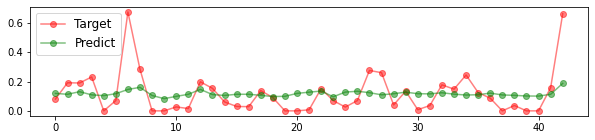

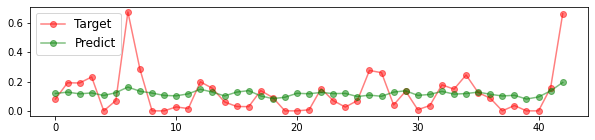

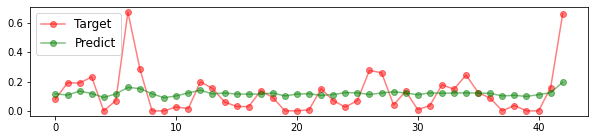

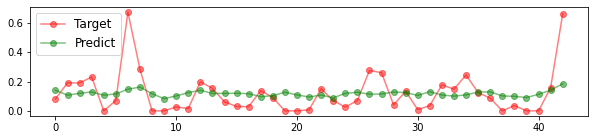

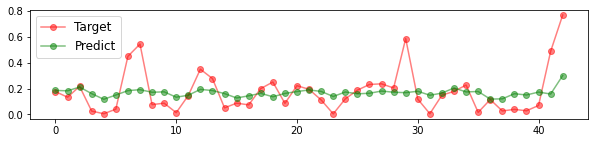

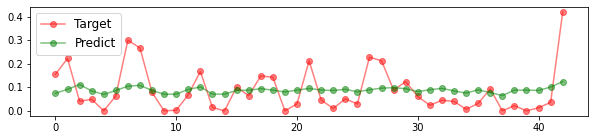

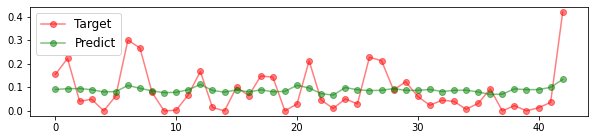

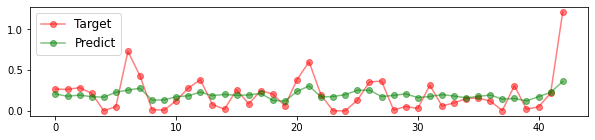

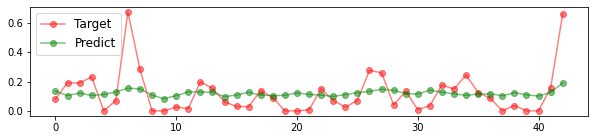

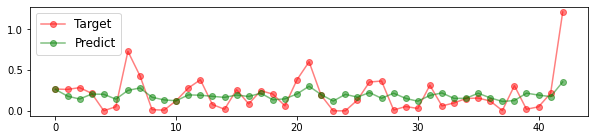

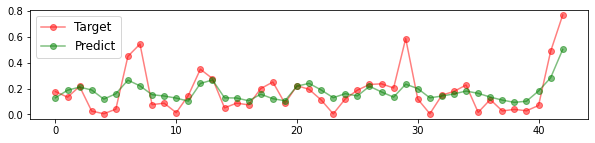

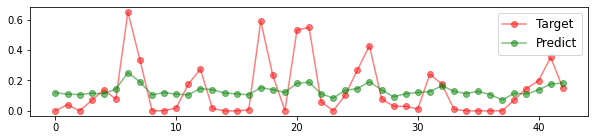

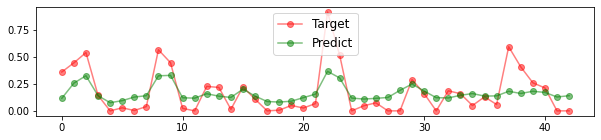

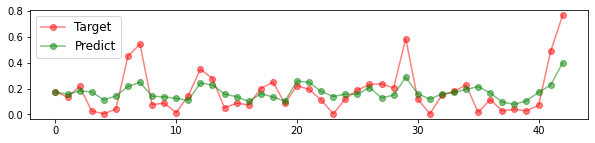

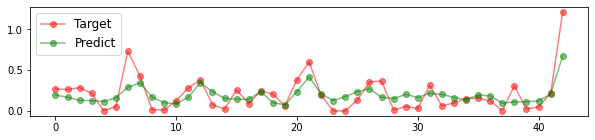

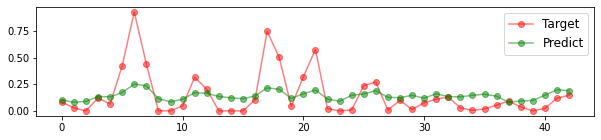

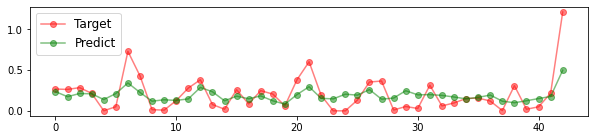

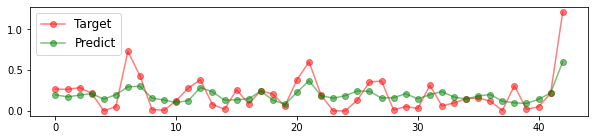

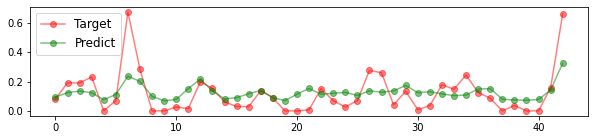

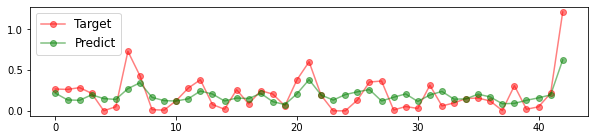

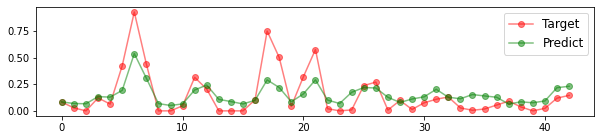

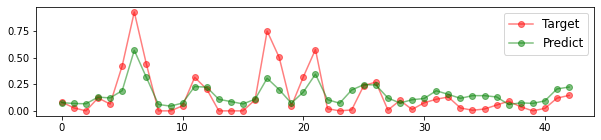

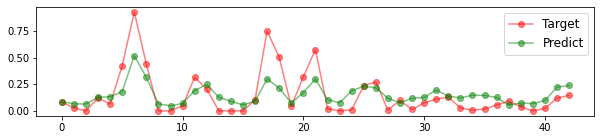

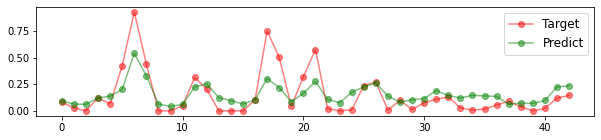

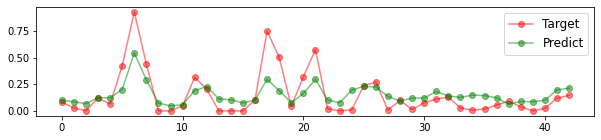

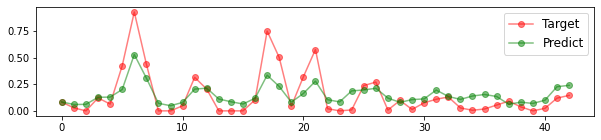

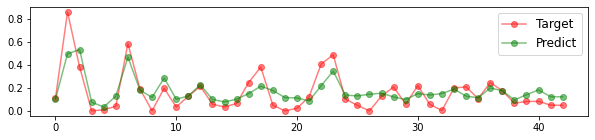

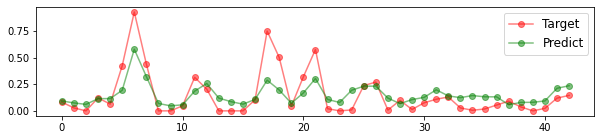

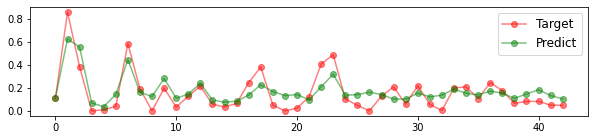

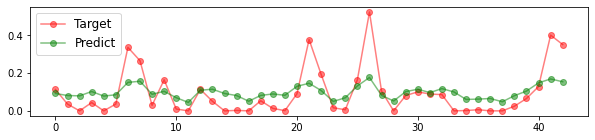

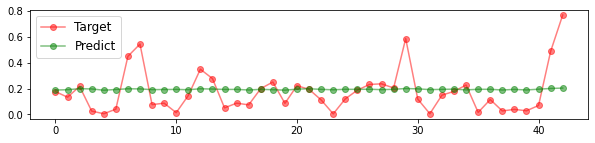

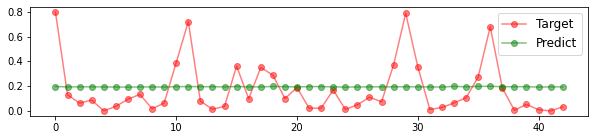

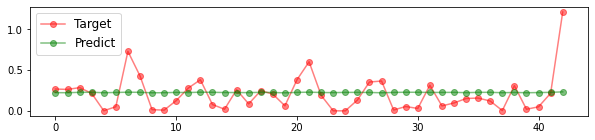

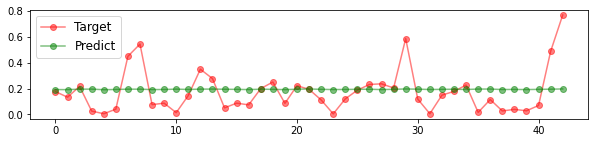

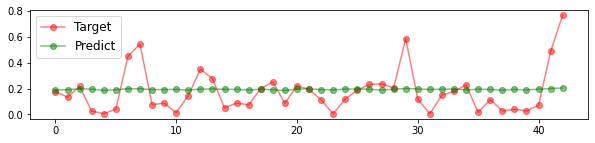

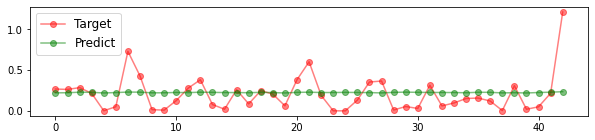

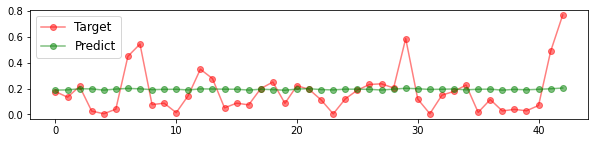

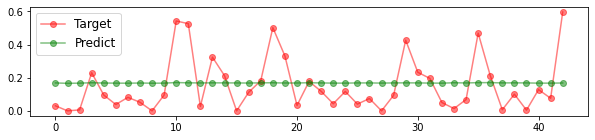

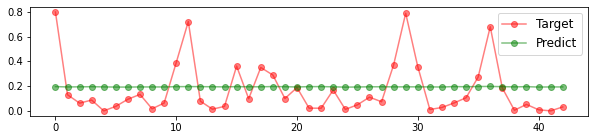

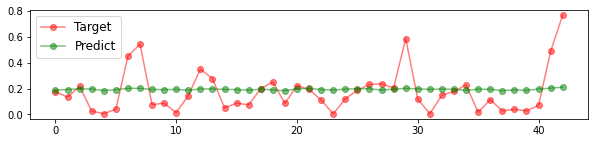

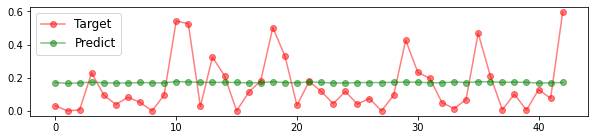

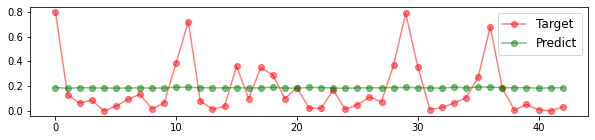

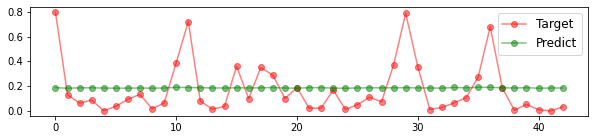

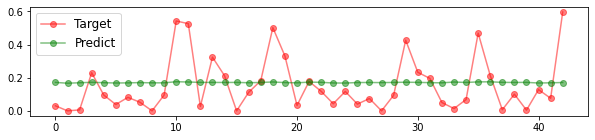

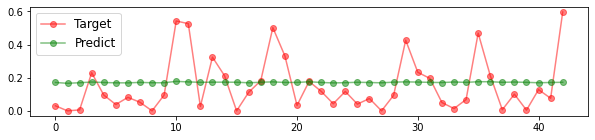

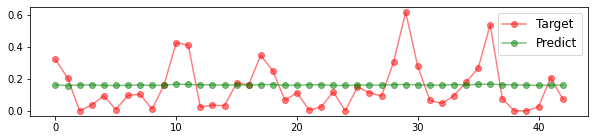

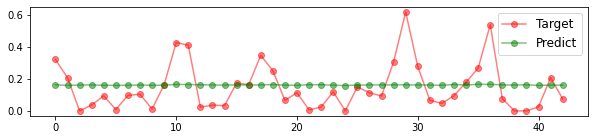

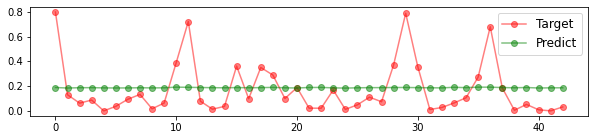

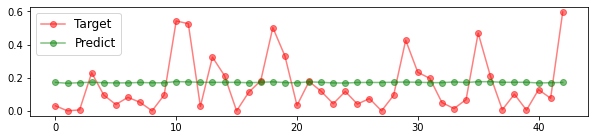

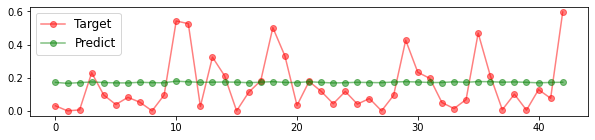

In [20]:
#test model
modeltestloss=np.zeros((5,10))
for gg in range(5):
    bnum = str(gg+1) #batch number
    for ii in range(10):
        modelname=str(ii+1)
        tempmodel = ModelSemiSL3d1_Conv3d_1()
        tempmodel.load_state_dict(torch.load\
            ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_1_ventral_less_upandlow_bnum_'+bnum+'_seed_'+modelname+'_weight_4.pth'))
        tempmodel=tempmodel.to(device_cpu)
        CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
        modeltestloss[gg,ii] = CC

torch.cuda.empty_cache()
#modeltestloss=np.array(modeltestloss)
print (modeltestloss.shape)
print (modeltestloss)
print (np.mean(modeltestloss,axis=1))

(96, 2, 8, 28, 28)


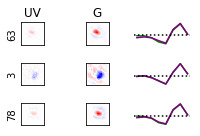

In [52]:
# save svd results of example neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
#
#visualize final layer of model
tempmodel= ModelSemiSL3d1_Conv3d_1()
tempmodel.load_state_dict(torch.load('./out/20200429_v5_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_seed_1_weight_6'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1  =tempmodel.conv1.data.clone().detach()
conv1_bias   =tempmodel.conv1_bias.data.clone().detach()
fc1_weight=tempmodel.fc1.weight.data.clone().detach()
fc1_bias  =tempmodel.fc1.bias.data.clone().detach()
tempmodel= ModelSemiSL3d1_Conv3d_1_copy(conv1,conv1_bias,fc1_weight,fc1_bias)
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,8,28,28))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[63,3,78] #np.arange(len(RF_fl_np)) #
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

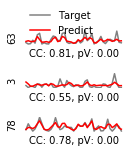

In [53]:
#plot prediction results for example neurons
tempmodel= ModelSemiSL3d1_Conv3d_1()
tempmodel.load_state_dict(torch.load('./out/20200429_v5_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_seed_1_weight_6'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y,z)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu)
z=z/255.0
z[:,0,:,:,:]=z[:,0,:,:,:]-sky_bg_mean_f[0]
z[:,1,:,:,:]=z[:,1,:,:,:]-sky_bg_mean_f[1]
if 'Conv3d_1' in tempmodel.__class__.__name__:
    b_z = torch.from_numpy(z).float().to(device_cpu)
elif 'Conv3d_2' in tempmodel.__class__.__name__:
    b_z = torch.from_numpy(z).float().to(device_cpu)
    b_z[:,:,-1,:,:]=0 # 7th frame is set to 0 after preprocessing
with torch.no_grad():
    encoded,_,_ = tempmodel(b_x,b_z)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[7:,:] #use_pad0_sti=False
y=y[7:,:] #use_pad0_sti=False
#
nums_eg=[63,3,78] 
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='red',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()